# LLM Metrics Visualization Example (Using Pre-calculated Results)

 This notebook demonstrates how to use the optional visualization functions
 (`plot_metric_comparison`, `plot_radar_comparison`) with pre-calculated metric results
 loaded from a `.pkl` file, similar to the workflow in the `llm_faq` and `DeepSeek` examples.

 **Workflow:**
 1. Load metric results stored in a `.pkl` file.
 2. Transform these raw loaded results into a single, long-format pandas DataFrame where each row represents a specific metric score for a model. This DataFrame will contain unaggregated scores if multiple entries were present in the raw data.
 3. Use the plotting functions (`plot_metric_comparison`, `plot_radar_comparison`) with this DataFrame. The plotting functions will internally aggregate these scores (e.g., using `numpy.mean` by default, or a custom function passed via the `aggregate_func` parameter) before generating the visualisations.

 **Requirements:**
 - `llm_metrics` library installed.
 - Optional visualization dependencies installed: `poetry install --all-extras`
   (This installs `matplotlib`, `seaborn`, `pandas`, `numpy`).
 - A `.pkl` file containing metric results (e.g., `response_metrics.pkl` from the `llm_faq` example data).


In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import warnings
import json 

In [2]:
try:
    # Assuming prepare_results_dataframe is exposed via llm_metrics.visualize or llm_metrics directly
    # Adjust the import based on your __init__.py structure
    from llm_metrics import (
        prepare_results_dataframe,
        plot_radar_comparison,
        plot_metric_comparison
    )
    import matplotlib.pyplot as plt # Needed to show plots
    VISUALIZATION_ENABLED = True
    print("Visualization libraries loaded successfully.")
except ImportError as e:
    print(f"WARNING: Visualization libraries not installed. Skipping plotting examples.")
    print(f"Error details: {e}")
    print("To enable plotting, install with: pip install llm_metrics[visualization]")
    VISUALIZATION_ENABLED = False
    # Define dummy functions if needed to prevent later NameErrors
    def prepare_results_dataframe(*args, **kwargs): return None
    def plot_radar_comparison(*args, **kwargs): return None
    def plot_metric_comparison(*args, **kwargs): return None
    def plt(): return None # Dummy plt


Visualization libraries loaded successfully.


In [3]:
results_pkl_path = './response_metrics.pkl'

In [4]:
# Check if the file exists relative to the 'examples' directory
if not os.path.exists(results_pkl_path):
     # Try path relative to project root if not found in examples subdir
     alt_path = os.path.join("examples", results_pkl_path)
     if os.path.exists(alt_path):
         results_pkl_path = alt_path
     else:
        print(f"Error: Results file not found at '{results_pkl_path}' or '{alt_path}'.")
        print("Please ensure the path is correct and the metrics have been calculated and saved.")
        results_raw = None # Ensure variable exists
else:
    try:
        with open(results_pkl_path, 'rb') as f:
            results_raw = pickle.load(f)
        print(f"Successfully loaded raw results from: {results_pkl_path}")
        if results_raw:
            first_model = list(results_raw.keys())[0]
            print(f"\nExample structure for model '{first_model}' (first 2 entries):")
            print(results_raw[first_model][:2])
    except Exception as e:
        print(f"Error loading or reading {results_pkl_path}: {e}")
        results_raw = None


Successfully loaded raw results from: ./response_metrics.pkl

Example structure for model 'phi' (first 2 entries):
[{'BLEU': 7.899509090909156e-05, 'ROUGE-L': 0.08333333333333333, 'JSD': 0.802977443756429, 'Jaccard': 0.03225806451612903, 'Levenshtein': 0.21073558648111335, 'BERTScore': 0.529816746711731}, {'BLEU': 0.0063720658187751186, 'ROUGE-L': 0.1346153846153846, 'JSD': 0.7346310402512901, 'Jaccard': 0.10810810810810811, 'Levenshtein': 0.4, 'BERTScore': 0.562281608581543}]


In [5]:
results_aggregated = {}
if results_raw and VISUALIZATION_ENABLED:
    print("\nAggregating scores (calculating mean)...")
    try:
        for model, scores_list in results_raw.items():
            if not scores_list: # Handle empty list for a model
                print(f"Warning: No scores found for model '{model}'. Skipping aggregation.")
                continue
            # Use pandas to easily calculate mean per metric
            # This assumes scores_list is a list of flat dictionaries
            # If ROUGE/BERTScore are nested dicts in the pkl, more complex handling is needed here first
            df_temp = pd.DataFrame(scores_list)

            # Calculate mean, ensuring only numeric types are considered
            numeric_df = df_temp.select_dtypes(include=np.number)
            if numeric_df.empty:
                 print(f"Warning: No numeric scores found for model '{model}' after loading. Skipping.")
                 continue

            results_aggregated[model] = numeric_df.mean().to_dict()

        print("Aggregation complete.")
        print("\nAggregated Results (Mean Scores):")
        # Use a custom encoder for NaN -> null in JSON output for display
        class NpEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, np.integer): return int(obj)
                if isinstance(obj, np.floating): return float(obj) if not np.isnan(obj) else None # Handle NaN
                if isinstance(obj, np.ndarray): return obj.tolist()
                return super(NpEncoder, self).default(obj)
        print(json.dumps(results_aggregated, indent=2, cls=NpEncoder))

    except Exception as e:
        print(f"Error during score aggregation: {e}")
        results_aggregated = {} # Reset on error
elif not results_raw:
     print("\nSkipping aggregation because raw results failed to load.")
else:
     print("\nSkipping aggregation because visualization libraries are disabled.")



Aggregating scores (calculating mean)...
Aggregation complete.

Aggregated Results (Mean Scores):
{
  "phi": {
    "BLEU": 0.007317766308037961,
    "ROUGE-L": 0.13256668888554188,
    "JSD": 0.7322779885938606,
    "Jaccard": 0.09776037329211132,
    "Levenshtein": 0.36793679597800827,
    "BERTScore": 0.5051166191697121
  },
  "llama": {
    "BLEU": 0.00906650922709658,
    "ROUGE-L": 0.16498710221667837,
    "JSD": 0.7156423309877633,
    "Jaccard": 0.11874110119592332,
    "Levenshtein": 0.38764141556914816,
    "BERTScore": 0.5274115592241287
  },
  "gemini": {
    "BLEU": 0.008377109621305449,
    "ROUGE-L": 0.1385989926704349,
    "JSD": 0.7432601220421715,
    "Jaccard": 0.09203854137259256,
    "Levenshtein": 0.3678941231393626,
    "BERTScore": 0.484552389383316
  },
  "mixtral": {
    "BLEU": 0.00907712409319465,
    "ROUGE-L": 0.15816819788166678,
    "JSD": 0.7285162655296894,
    "Jaccard": 0.10771496145744464,
    "Levenshtein": 0.37510304648180676,
    "BERTScore": 0.5

In [6]:
results_df = None # Initialize
if results_aggregated and VISUALIZATION_ENABLED:
    print("\nPreparing DataFrame from aggregated results...")
    try:
        # Pass the aggregated dictionary directly
        results_df = prepare_results_dataframe(results_aggregated)
        print("\nPrepared DataFrame:")
        print(results_df)
    except Exception as e:
         print(f"\nError preparing DataFrame: {e}")
         results_df = None # Ensure it's None on error
elif not results_aggregated:
    print("\nSkipping DataFrame preparation as aggregation failed or produced no results.")
else:
    print("\nSkipping DataFrame preparation as visualization is disabled.")



Preparing DataFrame from aggregated results...

Prepared DataFrame:
   model_name  metric_name     score
0         phi         BLEU  0.007318
1         phi      ROUGE-L  0.132567
2         phi          JSD  0.732278
3         phi      Jaccard  0.097760
4         phi  Levenshtein  0.367937
5         phi    BERTScore  0.505117
6       llama         BLEU  0.009067
7       llama      ROUGE-L  0.164987
8       llama          JSD  0.715642
9       llama      Jaccard  0.118741
10      llama  Levenshtein  0.387641
11      llama    BERTScore  0.527412
12     gemini         BLEU  0.008377
13     gemini      ROUGE-L  0.138599
14     gemini          JSD  0.743260
15     gemini      Jaccard  0.092039
16     gemini  Levenshtein  0.367894
17     gemini    BERTScore  0.484552
18    mixtral         BLEU  0.009077
19    mixtral      ROUGE-L  0.158168
20    mixtral          JSD  0.728516
21    mixtral      Jaccard  0.107715
22    mixtral  Levenshtein  0.375103
23    mixtral    BERTScore  0.515218
24    


--- Generating Bar Plot for Average BLEU ---


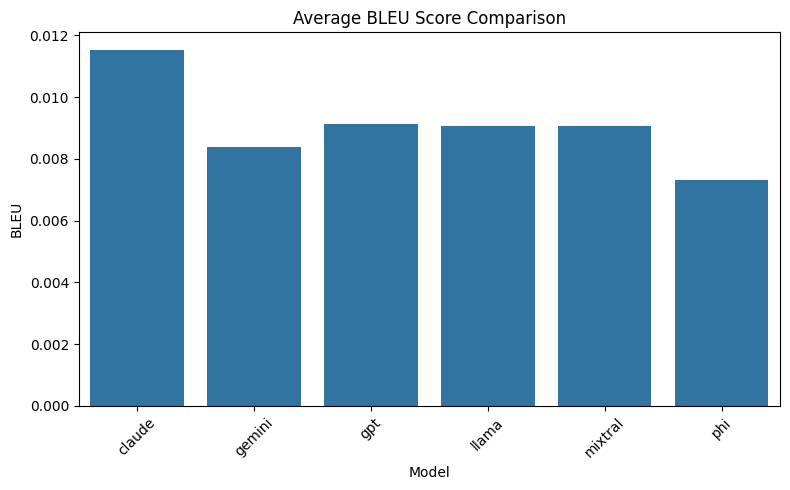

In [7]:
from matplotlib import axis


if VISUALIZATION_ENABLED and results_df is not None and not results_df.empty:
    print("\n--- Generating Bar Plot for Average BLEU ---")
    try:
        # --- Choose Metric ---
        metric_to_plot = 'BLEU' # Try changing to 'ROUGE-L', 'Jaccard', 'BERTScore' etc. (must exist in results_df)

        if metric_to_plot not in results_df['metric_name'].unique():
             print(f"Error: Metric '{metric_to_plot}' not found in the prepared DataFrame. Available: {results_df['metric_name'].unique()}")
        else:
            fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
            plot_metric_comparison(
                df=results_df,
                metric_name='BLEU',
                axis=ax_bar,
                title=f"Average {metric_to_plot} Score Comparison"
            )
            plt.show()
    except Exception as e:
        print(f"An unexpected error occurred during bar plotting: {e}")

elif VISUALIZATION_ENABLED:
    print("\nSkipping bar plot because DataFrame preparation failed or DataFrame is empty.")
else:
    print("\nSkipping bar plot because visualization is disabled.")



--- Generating Radar Plot from Average Scores ---
Plotting radar with metrics: ['BLEU', 'ROUGE-L', 'JSD', 'Jaccard', 'Levenshtein', 'BERTScore']


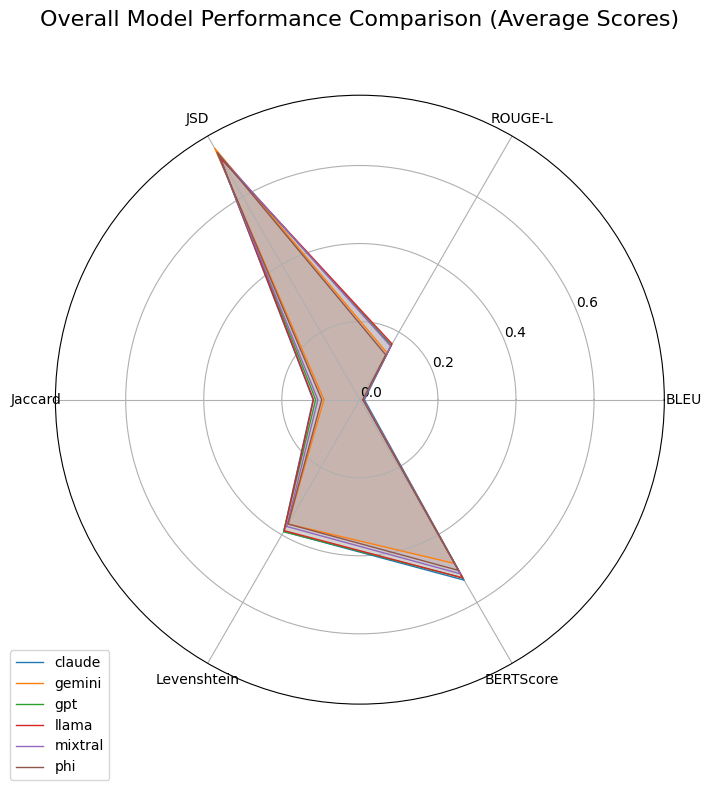

In [8]:
if VISUALIZATION_ENABLED and results_df is not None and not results_df.empty:
    print("\n--- Generating Radar Plot from Average Scores ---")
    try:
        # Select metrics available in the aggregated results
        available_metrics = results_df['metric_name'].unique().tolist()
        # Example: Use all available metrics, or select a subset
        metrics_for_radar = available_metrics
        # metrics_for_radar = ['BLEU', 'ROUGE-L', 'BERTScore', 'Jaccard']

        # Filter metrics_for_radar to only those actually present
        metrics_for_radar = [m for m in metrics_for_radar if m in available_metrics]

        if not metrics_for_radar:
            print("Error: No valid metrics selected or available for the radar plot.")
        elif len(metrics_for_radar) < 3:
            print(f"Warning: Only {len(metrics_for_radar)} metrics available/selected. Radar plots are best with 3 or more.")
            # Proceeding anyway for testing purposes

        if metrics_for_radar:
            print(f"Plotting radar with metrics: {metrics_for_radar}")
            fig_radar, ax_radar = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
            plot_radar_comparison(
                df=results_df, 
                metrics=metrics_for_radar,
                axis=ax_radar,
                title="Overall Model Performance Comparison (Average Scores)"
            )
            plt.show()

    except Exception as e:
        print(f"An unexpected error occurred during radar plotting: {e}")

elif VISUALIZATION_ENABLED:
    print("\nSkipping radar plot because DataFrame preparation failed or DataFrame is empty.")
else:
    print("\nSkipping radar plot because visualization is disabled.")
